# International Workshop on Spectroscopy and Chemometrics 2022
# Data Challenge Solution - Tabular Models

# Data Description

Notes and Objective:
The dataset has been divided (by the organizers) into two Excel sheets
- Training dataset: contains the value to predict (cow diet) and the spectra
- Test dataset: contains only the spectra
The test dataset contains 1,089 spectra.

**The aim of the analysis is to predict the cow diet for the samples in the test dataset.**

**Sample collection**
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 Holstein- Friesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. 

The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

O’Callaghan, T. F., D. Hennessy, S. McAuliffe, K. N. Kilcawley, M. O’Donovan, P. Dillon, R. P. Ross, and C. Stanton. 2016. Effect of pasture versus indoor feeding systems on raw milk composition and quality over an entire lactation. J. Dairy Sci. 99:9424–9440. https://doi.org/10.3168/jds.2016-10985.


# Run tabular experiments:

+ Useful recent ref: https://www.journalofdairyscience.org/article/S0022-0302(21)00909-7/fulltext
+ In that work LDA and LASSO work well.
+ check water regions: 172-205 536-728 748-end
+ use 4-fold cv for comparison of results of diff algos; also look at single train-test split
+ tuning models: grid search
+ compare results on fixed train_test split (eg avg RidgeCV and GBR models)?
+ voting windows to automatically find important regions of the time series
+ other ideas: for final submission, we could average the best models and submit the average (eg average the tabular and the TS methods); it would be nice to look more into explanation methods for time series, eg saliency maps obtained with different methods such as LIME and Shapley

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import time

#data
from sklearn.preprocessing import StandardScaler

#linear models
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
#from sklearn.cross_decomposition import PLSRegression

#linear models
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import RidgeClassifier, LassoClassifier, ElasticNetClassifier, RidgeClassifierCV, LassoClassifierCV, ElasticNetClassifierCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import LinearSVC

#from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#https://hub.packtpub.com/rotation-forest-classifier-ensemble-based-feature-extraction/
from rotation_forest import RotationTreeClassifier, RotationForestClassifier

#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsClassifier

#neural networks
from sklearn.neural_network import MLPClassifier

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVC

#deep learning
#tbd: 

#evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


from patsy import dmatrices
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted
#from pandas_profiling import ProfileReport

In [4]:
#training_df = pd.read_excel('data/vmdata.xlsx', 0, engine='openpyxl')
#test_df = pd.read_excel('data/vmdata.xlsx', 1, engine='openpyxl')
#print("Training shape: ", training_df.shape)
#print("Test shape: ", test_df.shape)

In [5]:
#training_df.to_csv("data/train.csv", index = False)
#test_df.to_csv("data/test.csv", index = False)

In [6]:
training_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [7]:
print("Training shape: ", training_df.shape)
print("Test shape: ", test_df.shape)

Training shape:  (3275, 1061)
Test shape:  (1089, 1060)


In [8]:
"Total cows: ",  training_df.shape[0] + test_df.shape[0]

('Total cows: ', 4364)

In [9]:
training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,GRS,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,GRS,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,GRS,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863
3,GRS,1.204441,1.193640,1.183685,1.174031,1.164706,1.155768,1.147259,1.139031,1.130472,...,0.972673,0.973021,0.973390,0.973784,0.974206,0.974654,0.975121,0.975456,0.975953,0.976483
4,GRS,1.280609,1.264384,1.250152,1.237041,1.224849,1.213294,1.202137,1.191109,1.179676,...,0.958123,0.958400,0.958773,0.959264,0.959864,0.960536,0.961223,0.961681,0.962278,0.962797


In [10]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Columns: 1061 entries, Diet to col1060
dtypes: float64(1060), object(1)
memory usage: 26.5+ MB


In [11]:
training_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,3275.0,1.224632,0.109307,0.200451,1.201450,1.233044,1.263995,1.489349
col2,3275.0,1.212087,0.107605,0.197335,1.190346,1.220362,1.249970,1.463645
col3,3275.0,1.200541,0.106066,0.194482,1.180232,1.208841,1.236811,1.440033
col4,3275.0,1.189475,0.104590,0.191707,1.170511,1.197907,1.224258,1.416911
col5,3275.0,1.178933,0.103169,0.189006,1.161068,1.187339,1.212192,1.393804
...,...,...,...,...,...,...,...,...
col1056,3275.0,0.934065,0.081377,0.138791,0.925075,0.944540,0.960999,0.999148
col1057,3275.0,0.934470,0.081405,0.138879,0.925458,0.944912,0.961418,0.999596
col1058,3275.0,0.934752,0.081425,0.138947,0.925821,0.945188,0.961694,1.000010
col1059,3275.0,0.935129,0.081454,0.139043,0.926208,0.945576,0.962166,1.000674


In [12]:
training_df['Diet'].value_counts()

CLV    1120
GRS    1094
TMR    1061
Name: Diet, dtype: int64

In [13]:
#outlier spectra
#training_df[training_df['col1'] < 1]

In [14]:
#remove outlier spectra with col1 < 1
training_df = training_df[training_df['col1'] >= 1]

In [15]:
training_df['Diet'].value_counts()

CLV    1108
GRS    1082
TMR    1054
Name: Diet, dtype: int64

In [16]:
test_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.317418,1.299994,1.284558,1.270085,1.256384,1.243233,1.230456,1.217821,1.204802,1.190368,...,0.937689,0.938134,0.938614,0.939119,0.939631,0.940134,0.940621,0.940953,0.941424,0.941899
1,1.316640,1.299685,1.284699,1.270432,1.256800,1.243672,1.230912,1.218294,1.205288,1.190875,...,0.919305,0.919648,0.920018,0.920458,0.920975,0.921541,0.922106,0.922466,0.922939,0.923350
2,1.209746,1.196516,1.184740,1.174105,1.164847,1.156824,1.149617,1.142574,1.134739,1.124788,...,0.970130,0.970361,0.970555,0.970754,0.971008,0.971354,0.971804,0.972164,0.972751,0.973371
3,1.336356,1.318198,1.301790,1.286056,1.271100,1.256870,1.243191,1.229715,1.215774,1.200255,...,0.922056,0.922449,0.922868,0.923344,0.923886,0.924473,0.925061,0.925436,0.925920,0.926315
4,1.332259,1.313666,1.297593,1.282746,1.268823,1.255356,1.241928,1.228219,1.213810,1.197925,...,0.918629,0.919234,0.919818,0.920360,0.920856,0.921318,0.921762,0.922058,0.922488,0.922912


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Columns: 1060 entries, col1 to col1060
dtypes: float64(1060)
memory usage: 8.8 MB


In [18]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1089.0,1.225367,0.117075,0.202345,1.201685,1.233364,1.266169,1.424172
col2,1089.0,1.212738,0.115314,0.199096,1.190699,1.220993,1.252325,1.402551
col3,1089.0,1.201104,0.113723,0.196168,1.180659,1.209428,1.239401,1.382655
col4,1089.0,1.189947,0.112200,0.193352,1.170665,1.198623,1.226548,1.363035
col5,1089.0,1.179314,0.110734,0.190633,1.161789,1.188106,1.214937,1.343277
...,...,...,...,...,...,...,...,...
col1056,1089.0,0.931040,0.087074,0.141882,0.921541,0.942811,0.959861,0.997951
col1057,1089.0,0.931446,0.087106,0.141984,0.921972,0.943132,0.960300,0.998330
col1058,1089.0,0.931730,0.087127,0.142056,0.922178,0.943395,0.960672,0.998650
col1059,1089.0,0.932114,0.087156,0.142149,0.922488,0.944017,0.961060,0.999195


In [19]:
#test_df[test_df['col1'] < 1]

In [20]:
#remove outlier spectra with col1 < 1
test_df = test_df[test_df['col1'] >= 1]

The data is arranged such that each row belongs to a particular cow. 

In [21]:
#training_df.describe().T

In [22]:
#test_df.describe().T

In [23]:
#training_df.isnull().sum()

In [24]:
#test_df.isnull().sum()

# Targets: GRS, CLV, TMR

In [25]:
pd.set_option('display.max_rows', training_df.shape[0]+1)

In [26]:
target_columns = ["CLV", "GRS", "TMR"]
features = [col for col in training_df.columns if col not in 'Diet']
#print(features)
training_df[features].head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
0,1.285407,1.270682,1.256961,1.243545,1.230510,1.217927,1.205841,1.194133,1.182280,1.169188,...,0.953018,0.953452,0.953923,0.954405,0.954882,0.955351,0.955824,0.956178,0.956678,0.957184
1,1.184143,1.174105,1.164920,1.156222,1.148060,1.140399,1.133123,1.125951,1.118246,1.108886,...,0.978003,0.978359,0.978767,0.979192,0.979599,0.979972,0.980313,0.980553,0.980892,0.981262
2,1.367154,1.348666,1.331992,1.315673,1.299387,1.283017,1.266661,1.250464,1.234278,1.217361,...,0.919751,0.920195,0.920649,0.921126,0.921624,0.922130,0.922627,0.922959,0.923418,0.923863


In [30]:
#shuffle the rows to deal with ordering by given target
training_df = training_df.sample(frac=1, random_state=0)

#X = training_df.iloc[:,1:]
#Y = training_df["Diet"]
X = training_df[features]
y = training_df['Diet']

training_df.head()

,Diet,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col1051,col1052,col1053,col1054,col1055,col1056,col1057,col1058,col1059,col1060
671,TMR,1.247125,1.234565,1.222631,1.210939,1.199757,1.189267,1.179502,1.170216,1.160707,...,0.943666,0.943991,0.944358,0.944767,0.945203,0.945644,0.946078,0.946376,0.946807,0.947255
2695,GRS,1.283992,1.269590,1.256347,1.243458,1.230868,1.218586,1.206643,1.194936,1.182974,...,0.967163,0.967225,0.967462,0.967919,0.968593,0.969436,0.970368,0.971057,0.971917,0.972613
1156,CLV,1.193668,1.182960,1.173127,1.163738,1.154824,1.146406,1.138463,1.130789,1.122762,...,0.942204,0.942929,0.943527,0.943961,0.944237,0.944386,0.944443,0.944451,0.944449,0.944479
464,TMR,1.211029,1.200202,1.190024,1.180023,1.170366,1.161255,1.152833,1.144985,1.137081,...,0.967027,0.967303,0.967580,0.967866,0.968172,0.968503,0.968870,0.969151,0.969599,0.970108
3226,GRS,1.255389,1.242610,1.230707,1.218986,1.207388,1.195910,1.184600,1.173399,1.161899,...,0.969181,0.969587,0.970077,0.970639,0.971257,0.971911,0.972579,0.973062,0.973680,0.974234


In [45]:
#X = training_df[features]
#y = training_df['Diet']
ridge = RidgeClassifier().fit(X, y)
y_pred = ridge.predict(X)
# Print the estimated linear regression coefficients.
#print("Features: \n", features)
#print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])


Intercept: 
 [  3.13398848 -28.67027295  24.53628448]

Features and coeficients: [('col1', array([ 0.32605869,  0.21834103,  0.17722726, ..., -0.26846248,
       -0.27457   , -0.27758055])), ('col2', array([ 0.89340788,  0.90858759,  0.9347545 , ..., -0.07223615,
       -0.0660347 , -0.060797  ])), ('col3', array([-1.21946657, -1.12692862, -1.11198176, ...,  0.34069863,
        0.3406047 ,  0.33837755]))]


In [46]:
#y.unique()

In [47]:
#unique_labels(y)

In [48]:
# Predicted scores for each example. 
def predict_eval(clf, X, y, y_pred):

    actual_vs_predicted = pd.concat([y, pd.DataFrame(y_pred, columns=['Predicted'], index=y.index)], axis=1)
    actual_vs_predicted.head()
    print(f'Accuracy: {accuracy_score(y, y_pred)}')

    cm = confusion_matrix(y, y_pred, labels=unique_labels(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=unique_labels(y))
    disp.plot()
    plt.grid(False)
    plt.show()

Accuracy: 0.5668927250308261


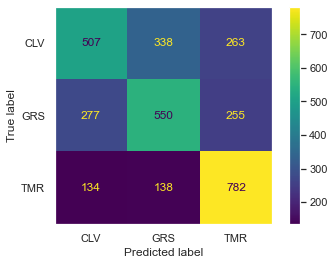

In [49]:
predict_eval(ridge, X, y, y_pred)

In [50]:
#This function is used repeatedly to compute all metrics
def printMetrics(y, y_pred):
    #classification evaluation measures
    print('\n==============================================================================')
    #print("Accuracy: ", metrics.accuracy_score(y, y_pred))
    #print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))
    print("Classification report:\n ", metrics.classification_report(y, y_pred))

In [51]:
#printMetrics(y, ridge_predictions)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#print("Training data:\n", pd.concat([X_train, y_train], axis=1).head())
#print("\nTest data:\n", pd.concat([X_test, y_test], axis=1).head())
print("Training data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Training data shape:  (1946, 1060) (1946,)
Test data shape:  (1298, 1060) (1298,)


Accuracy: 0.5693730729701952


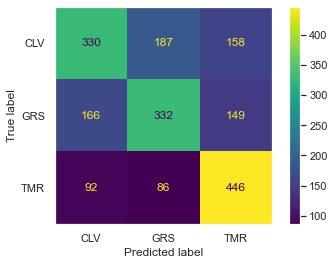


Intercept: 
 [ -5.13704969 -24.63202898  28.76907867]

Features and coeficients: [('col1', array([ 0.33063146,  0.2411481 ,  0.20226926, ..., -0.20667964,
       -0.20969928, -0.21176487])), ('col2', array([ 0.62988481,  0.63906493,  0.65051227, ..., -0.03980245,
       -0.03053288, -0.02289483])), ('col3', array([-0.96051626, -0.88021303, -0.85278153, ...,  0.24648209,
        0.24023215,  0.2346597 ]))]


In [55]:
# Train on the training sample and test on the test sample.
ridge = RidgeClassifier().fit(X_train, y_train)
y_pred = ridge.predict(X_train)
predict_eval(ridge, X_train, y_train, y_pred)

# Print the weights learned for each feature.
print("\nIntercept: \n", ridge.intercept_)
print("\nFeatures and coeficients:", list(zip(features, ridge.coef_))[:10])

In [56]:
#print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, y_pred)


Classification report:
                precision    recall  f1-score   support

         CLV       0.56      0.49      0.52       675
         GRS       0.55      0.51      0.53       647
         TMR       0.59      0.71      0.65       624

    accuracy                           0.57      1946
   macro avg       0.57      0.57      0.57      1946
weighted avg       0.57      0.57      0.57      1946



Accuracy: 0.4707241910631741


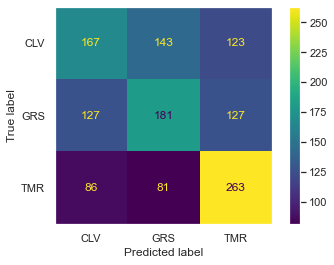


Classification report:
                precision    recall  f1-score   support

         CLV       0.44      0.39      0.41       433
         GRS       0.45      0.42      0.43       435
         TMR       0.51      0.61      0.56       430

    accuracy                           0.47      1298
   macro avg       0.47      0.47      0.47      1298
weighted avg       0.47      0.47      0.47      1298



In [57]:
# Predicted price on test set
y_pred = ridge.predict(X_test)
predict_eval(ridge, X_test, y_test, y_pred)
printMetrics(y_test, y_pred)
#print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1).head().sort_values('kappa_casein'))

In [58]:
def exp_single_clf(clf, X_train, X_test, y_train, y_test):    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [61]:
error_measures = ['accuracy']
scores = cross_validate(RidgeClassifier(), X, y, scoring=error_measures, cv=3)
scores

{'fit_time': array([0.12239504, 0.1327641 , 0.14577007]),
 'score_time': array([0.01291704, 0.01495981, 0.01668811]),
 'test_accuracy': array([0.474122  , 0.4773358 , 0.50601295])}

In [80]:
?rotation_forest

In [62]:
def printMetricsClassifCV(clf, X, y, metrics = ['acc']):
    #run cross-validation to compute the rmse for different folds, using different regression algorithms
    print('\n==============================================================================')
    scores = cross_validate(clf, X, y, scoring=metrics, cv=4)
    scores
    #print("MAE: ", -scores['test_neg_mean_absolute_error'])
    print("Acc: ", scores['test_accuracy'])

In [86]:
list_clf = [
            #RidgeClassifier(), 
            RidgeClassifierCV(), 
            RidgeClassifierCV(normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-4, 4, 10), normalize=True), 
            RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-6, 6, 10), normalize=True), 
            #RidgeClassifierCV(alphas=np.logspace(-10, 10, 10), normalize=True), 
            #LogisticRegression(penalty='l2'), LogisticRegression(penalty='l1'), 
            #GaussianNB(), 
            LinearDiscriminantAnalysis(), 
            #QuadraticDiscriminantAnalysis(), LinearSVC(),
            #RandomForestClassifier(n_estimators=100), 
            #GradientBoostingClassifier(n_estimators=100),
            #RotationForestClassifier(n_estimators=25, n_features_per_subset=3, rotation_algo='randomized'),
            #KNeighborsClassifier(n_neighbors=3),  
            #MLPClassifier(alpha=1, max_iter=1000), 
            #SVC(kernel="linear", C=0.025), 
            #SVC(gamma=2, C=1)
            ]
            
            
def algoCV(list_clf, X, y, folds = 3, error_measures = ['accuracy']):
    
    algos_df = pd.DataFrame({"algo":[], "acc": []})

    for algo in list_clf:
        print(algo)
        scores = cross_validate(algo, X, y, scoring=error_measures, cv=folds)
        #scores
        acc = scores['test_accuracy']
        fit_time = np.mean(scores['fit_time'])
        score_time = np.mean(scores['score_time'])
        
        algos_df = algos_df.append({"algo":str(algo), "acc": np.mean(acc)}, ignore_index=True)
             
        #print("acc: ", acc)
        print("accCV: ", np.mean(acc))
        #print("fit_time: ", fit_time)
        #print("score_time: ", score_time)
        print("time fit+score:", fit_time + score_time)
        print("\n")
    
    print(algos_df.sort_values('acc', ascending=False))
    algos_df.sort_values('acc').to_csv("cv" + str(folds) + "-acc.csv")
    
if __name__ == "__main__":
    
    algoCV(list_clf, X, y)
    

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))
accCV:  0.587237234413037
time fit+score: 0.8731599648793539


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), normalize=True)
accCV:  0.6251556744143364
time fit+score: 0.9513230323791504


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)
accCV:  0.7506151454889616
time fit+score: 1.1058243115743


RidgeClassifierCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                  normalize=True)
accCV:  0.7607897687212555
time fit+score: 1.2075311342875161


RidgeClassifierCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.6415888

# Findings so far

After comparing several algo with 3-fold cv:
+ RidgeClassifierCV(alphas=np.logspace(-5, 5, 10), normalize=True) works best, followed closely by LDA
